# Statistical Analysis
- Spearman Correlation
- Heatmap Visualization

In [13]:
# ==============================================================
# 🧩 PSEN1 Variant Predictors vs. Experimental Outcomes
# Spearman Correlation Analysis + Seaborn Heatmap Visualization
# ==============================================================

In [14]:
# --- 1️⃣ Import Libraries ---
import pandas as pd
import numpy as np
from scipy import stats
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt

# --- 2️⃣ Load Dataset ---
df = pd.read_csv("raw_data/PSEN1_Sun.csv")

In [15]:
# --- 3️⃣ Identify predictor and outcome columns ---
predictors = [c for c in df.columns if c.endswith('_rankscore')]
outcomes = ["AAO", "Total Activity", "Amount of Ab42", "Amount of Ab40", "Ab42/Ab40 ratio"]
outcomes = [c for c in outcomes if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]

print(f"✅ Using {len(predictors)} predictors and {len(outcomes)} outcomes.\n")

✅ Using 37 predictors and 5 outcomes.



In [16]:
# --- 4️⃣ Define helper function for safe correlation ---
def pairwise_corr(x, y, method="spearman"):
    """Compute correlation safely, ignoring NaNs."""
    mask = np.isfinite(x) & np.isfinite(y)
    n = int(mask.sum())
    if n < 3:
        return np.nan, np.nan, n
    if method == "spearman":
        r, p = stats.spearmanr(x[mask], y[mask])
    else:
        r, p = stats.pearsonr(x[mask], y[mask])
    return r, p, n

# --- 5️⃣ Compute correlations for all predictor–outcome pairs ---
rows = []
for pred in predictors:
    for out in outcomes:
        rho, pval, n = pairwise_corr(df[pred], df[out], method="spearman")
        rows.append({"Predictor": pred, "Outcome": out, "rho": rho, "p_value": pval, "n": n})

corr_df = pd.DataFrame(rows)

In [17]:
# --- 6️⃣ Enforce consistent order (no alphabetical sorting) ---
pred_order = CategoricalDtype(categories=predictors, ordered=True)
out_order = CategoricalDtype(categories=outcomes, ordered=True)
corr_df["Predictor"] = corr_df["Predictor"].astype(pred_order)
corr_df["Outcome"] = corr_df["Outcome"].astype(out_order)
corr_df = corr_df.sort_values(["Outcome", "Predictor"]).reset_index(drop=True)

# --- 7️⃣ Save results ---
corr_df.to_csv("processed_data/psen1_all_correlations_ordered.csv", index=False)
print("📁 Saved correlation results → psen1_all_correlations_ordered.csv")

📁 Saved correlation results → psen1_all_correlations_ordered.csv


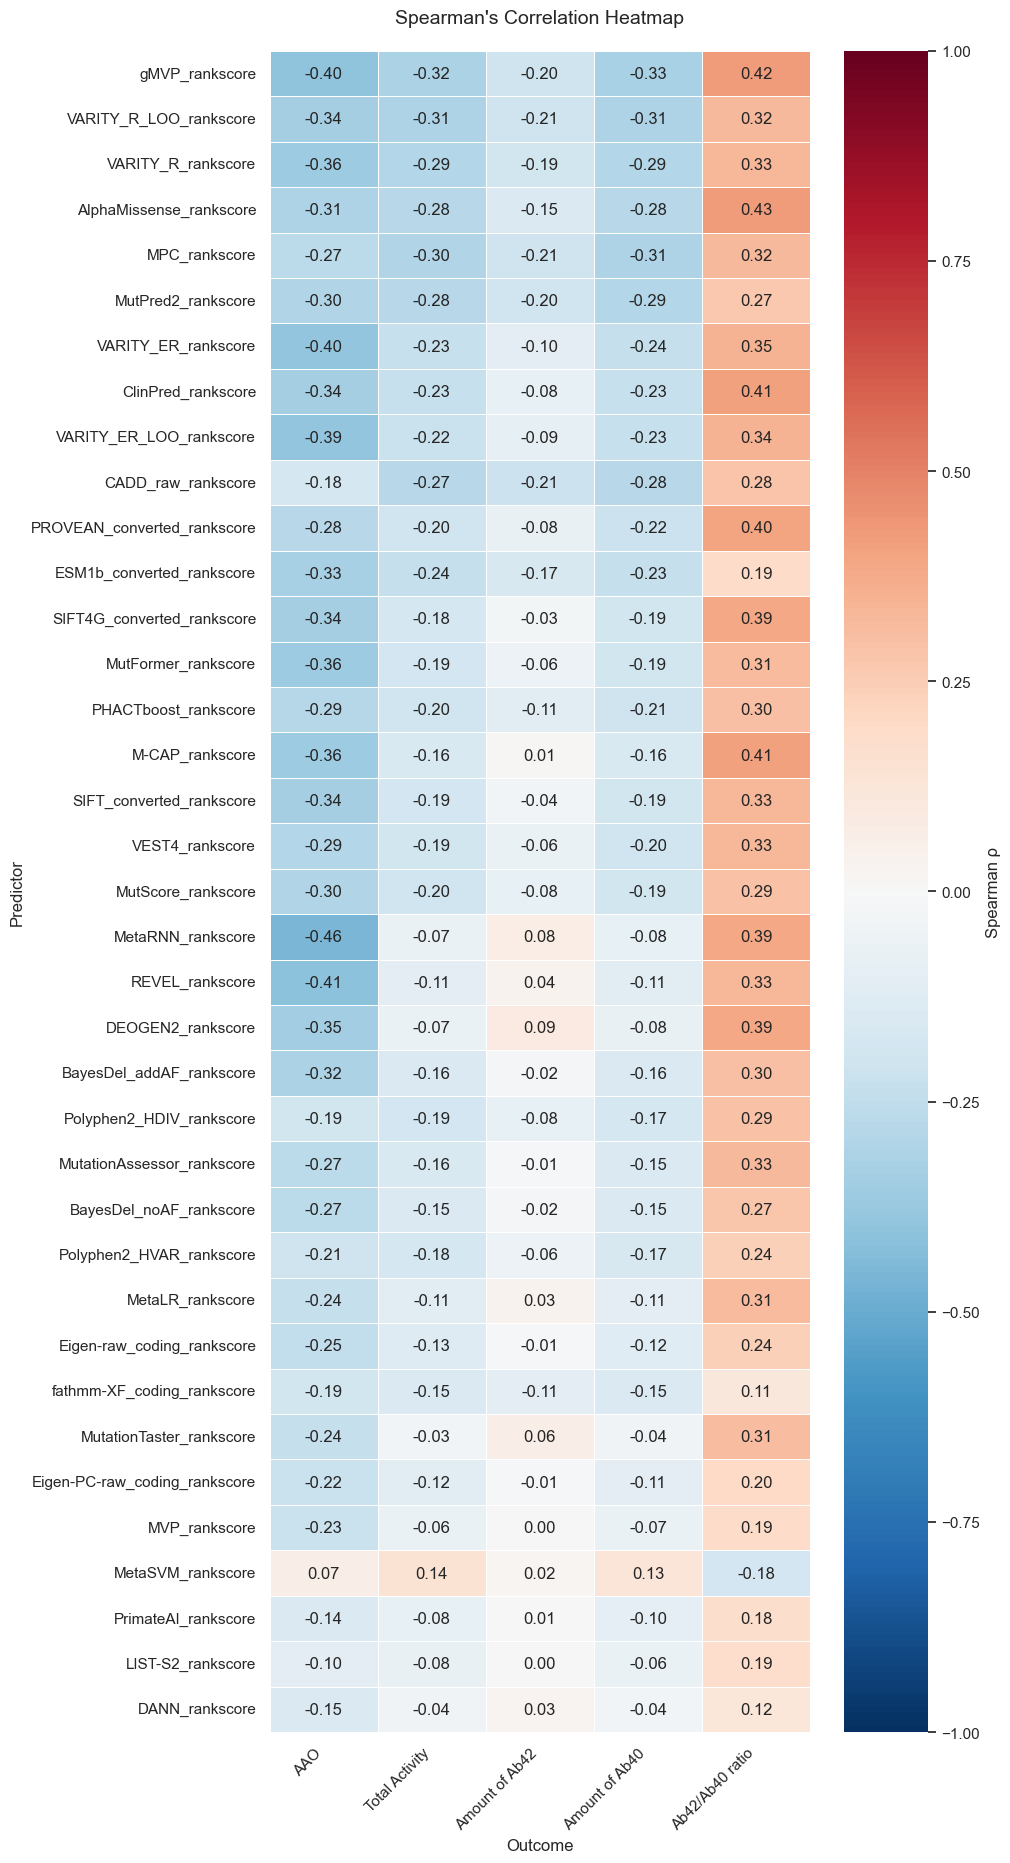

In [18]:
# --- 8️⃣ Pivot to wide format for heatmap ---
rho_matrix = corr_df.pivot(index="Predictor", columns="Outcome", values="rho")

# Optional: reorder predictors by average absolute correlation for nicer structure
row_order = rho_matrix.abs().mean(axis=1).sort_values(ascending=False).index
rho_matrix = rho_matrix.loc[row_order]

# --- 9️⃣ Plot Heatmap ---
plt.figure(figsize=(10, 0.4 * len(predictors) + 4))
sns.set(style='white', font_scale=1.0)

ax = sns.heatmap(
    rho_matrix,
    cmap="RdBu_r",        # red = negative, blue = positive
    vmin=-1, vmax=1,      # color range
    annot=True, fmt=".2f",# show correlation numbers
    linewidths=0.5,
    cbar_kws={"label": "Spearman ρ"}
)

ax.set_title("Spearman's Correlation Heatmap", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

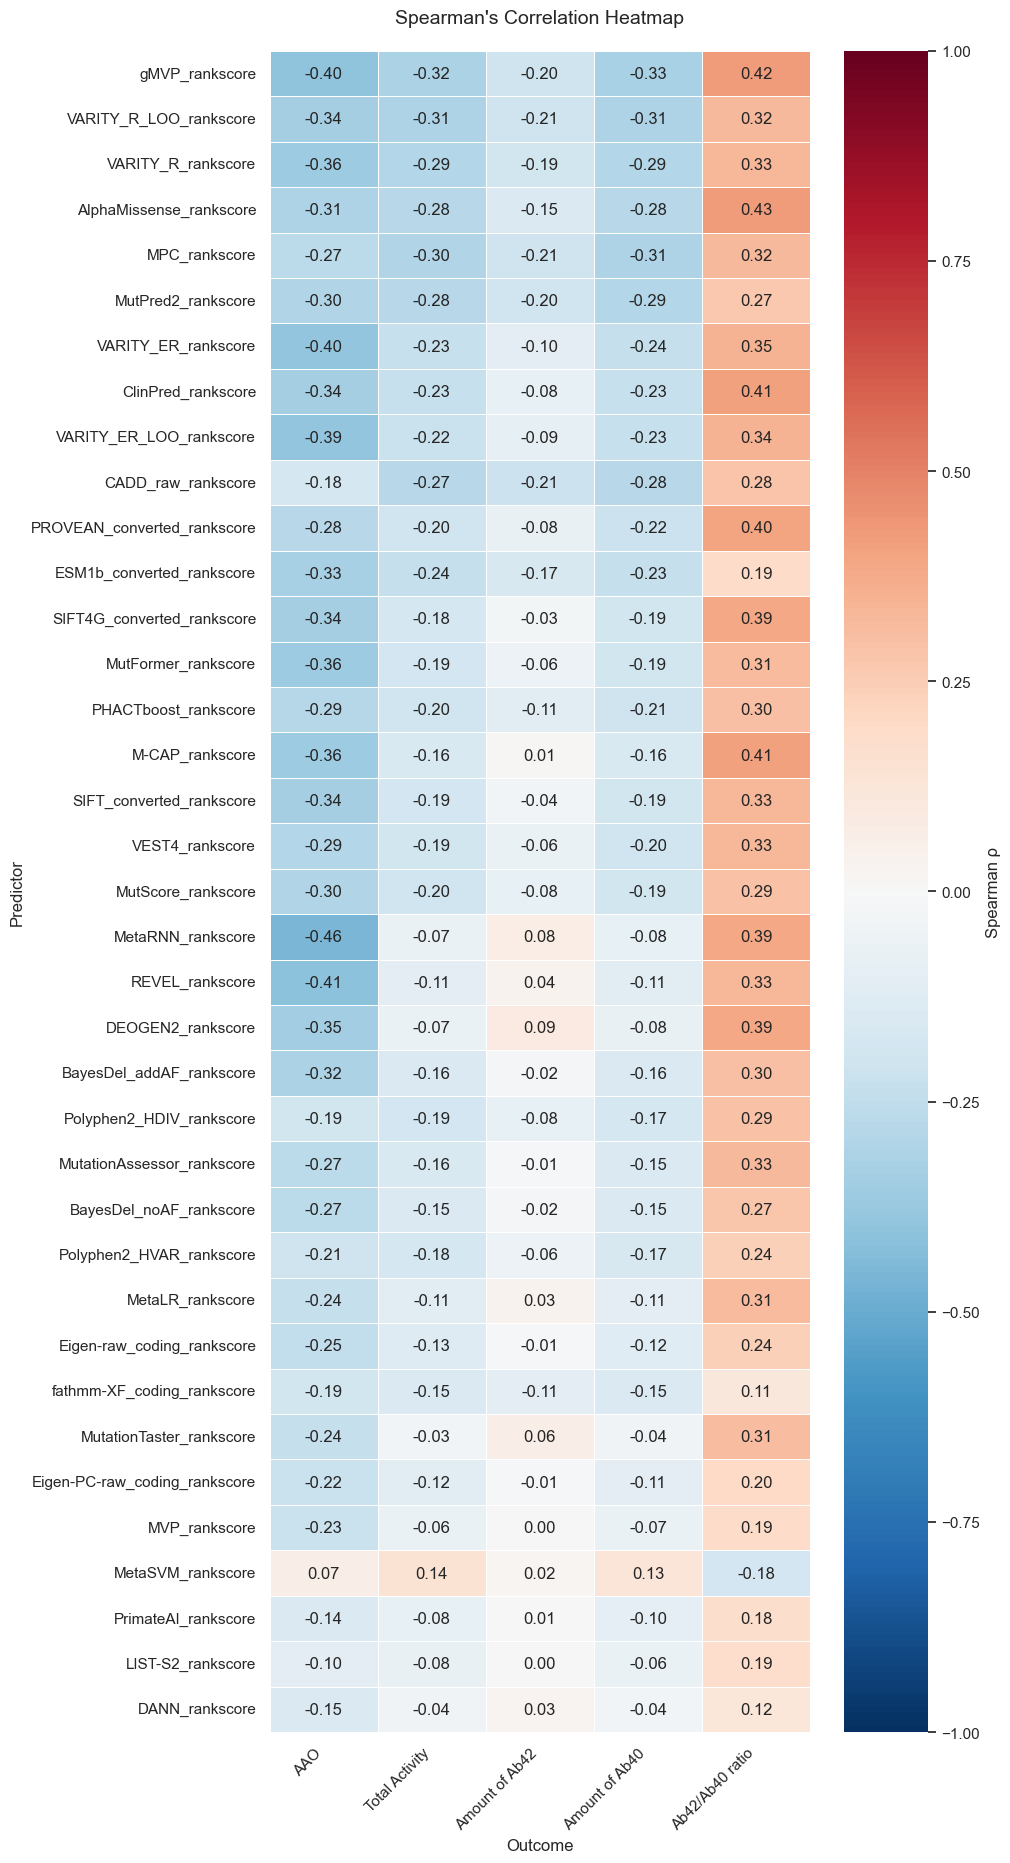

In [ ]:
# --- 9️⃣ Plot Heatmap ---
sns.set(style='white', font_scale=1.0)

# Create figure & axis handle so we can control saving
fig, ax = plt.subplots(figsize=(10, 0.4 * len(predictors) + 4))

sns.heatmap(
    rho_matrix,
    cmap="RdBu_r",        # red = negative, blue = positive
    vmin=-1, vmax=1,      # color scale range
    annot=True, fmt=".2f",# show numbers
    linewidths=0.5,
    cbar_kws={"label": "Spearman ρ"},
    ax=ax                 # <-- make sure it draws on this axis
)

ax.set_title("Spearman's Correlation Heatmap", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


In [ ]:
# --- 🔟 Save using the same figure handle ---
fig.savefig("figures/PSEN1_spearman_heatmap.png", dpi=600, bbox_inches='tight', facecolor='white')
plt.show()
print("📊 Saved heatmap → PSEN1_spearman_heatmap.png")